<a href="https://colab.research.google.com/github/TheCaveOfAdullam/FanalTest_motor_5.5kw_KdDpp/blob/main/FinalTest_Motor_5_5kw_L1norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=7bbaa6ddabfaec8013b751192fe6a33e649cb97aef0d22463d607c1ffbec58c1
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=beda7eead3cf855f371ab7e246fb84491abeddb36819546dad29c09da9989777
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import torch.nn.utils.prune as prune
import torch_pruning as tp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from ptflops import get_model_complexity_info
import time
import random

In [4]:
seed = 50
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # GPU 사용 시
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/motor_5.5kw_ver5'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 및 전처리 함수 정의
class VibrationDataset(Dataset):
    def __init__(self, base_dir, split, categories, label_encoder, segment_length=4000, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        self.segment_length = segment_length
        self.file_count = defaultdict(int)  # 카테고리별 파일 개수를 저장할 딕셔너리

        split_dir = os.path.join(base_dir, split)
        for category in categories:
            category_dir = os.path.join(split_dir, category)
            files = os.listdir(category_dir)
            self.file_count[category] = len(files)  # 카테고리별 파일 수 저장

            for file in files:
                file_path = os.path.join(category_dir, file)
                data = pd.read_csv(file_path, header=None, skiprows=1)  # 첫 행 건너뜀

                # 첫 번째 열(시간 데이터)을 제외하고 주파수 데이터만 선택
                frequency_data = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values

                # 데이터를 세그먼트로 분할
                num_segments = frequency_data.shape[0] // self.segment_length
                for i in range(num_segments):
                    segment = frequency_data[i * self.segment_length:(i + 1) * self.segment_length]
                    self.X.append(segment)  # 주파수 데이터만 포함
                    self.y.append(label_encoder.transform([category])[0])

        # 카테고리별 파일 개수 출력
        print(f"File count for '{split}' split:")
        for category, count in self.file_count.items():
            print(f"  {category}: {count} files")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T  # 2D 입력 (채널, 길이)로 변경
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# 레이블 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(categories)

# 데이터셋 준비
train_dataset = VibrationDataset(base_dir, 'train', categories, label_encoder)
val_dataset = VibrationDataset(base_dir, 'validation', categories, label_encoder)
test_dataset = VibrationDataset(base_dir, 'test', categories, label_encoder)

# 데이터 로더
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 첫 번째 데이터의 크기를 이용해 input_length 결정
first_sample, _ = train_dataset[0]
input_length = first_sample.shape[1]  # X는 (채널, 길이) 형태이므로 길이는 첫 번째 데이터의 두 번째 차원
print(f"Input length for one sample: {input_length}")

File count for 'train' split:
  normal: 2100 files
  fault_BB: 2100 files
  fault_RI: 2100 files
  fault_SM: 2100 files
File count for 'validation' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
File count for 'test' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
Input length for one sample: 4000


In [6]:
# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self, input_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=16, stride=16)  # 입력 채널을 1로 수정
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 출력 크기 계산
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, input_length)  # 1은 입력 채널 수
            sample_output = self.forward_conv_layers(sample_input)
            conv_output_size = sample_output.size(1) * sample_output.size(2)

        self.fc1 = nn.Linear(conv_output_size, 5000)
        #self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, len(categories))

    def forward_conv_layers(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(torch.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)  # Flattening
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# 모델 학습 함수 (학습 곡선 기록 추가)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

# 모델 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # 배치 손실의 합
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 평균 손실은 배치 개수로 나눔
    average_val_loss = val_loss / len(loader)  # len(loader)는 배치 개수
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy

In [8]:
# 모델 초기화 및 학습 설정
model = CNNModel(input_length=input_length)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

In [9]:
def detect_and_apply_l1_norm_pruning_for_filters(model, prune_ratio=0.5, example_inputs=None):
    if example_inputs is None:
        example_inputs = torch.randn(1, 1, input_length).to(next(model.parameters()).device)  # 입력 예제

    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)
    total_pruned = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d):  # Conv1D 레이어만 대상으로 설정
            # L1-노름 계산
            weight_data = module.weight.detach().cpu().numpy()
            l1_norm_scores = np.sum(np.abs(weight_data), axis=(1, 2))  # (out_channels, in_channels, kernel_size)

            # 중요도가 낮은 필터 선택
            num_filters = len(l1_norm_scores)
            num_pruned = int(prune_ratio * num_filters)
            prune_indices = np.argsort(l1_norm_scores)[:num_pruned]  # L1-노름 낮은 순으로 선택

            # 프루닝 대상 필터 제거
            if len(prune_indices) > 0 and len(prune_indices) < module.weight.shape[0]:
                pruning_group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=prune_indices)

                if pruning_group is not None:
                    pruning_group.prune()
                    total_pruned += len(prune_indices)
                    print(f"Pruned {len(prune_indices)} filters from {name}.")
            else:
                print(f"Skipping pruning for {name} as it would remove all filters.")

    print(f"L1-norm-based filter pruning applied. {total_pruned} filters pruned in total.")
    return model

Epoch 1/5: 100%|██████████| 788/788 [00:21<00:00, 35.98batch/s, accuracy=43.9, loss=0.548]


Epoch [1/5], Loss: 1.1941, Accuracy: 43.86%, Val Loss: 0.6094, Val Accuracy: 90.48%


Epoch 2/5: 100%|██████████| 788/788 [00:19<00:00, 39.72batch/s, accuracy=90.6, loss=0.225]


Epoch [2/5], Loss: 0.4156, Accuracy: 90.56%, Val Loss: 0.2980, Val Accuracy: 90.94%


Epoch 3/5: 100%|██████████| 788/788 [00:19<00:00, 39.76batch/s, accuracy=95, loss=0.0437]


Epoch [3/5], Loss: 0.2114, Accuracy: 95.01%, Val Loss: 0.1981, Val Accuracy: 93.72%


Epoch 4/5: 100%|██████████| 788/788 [00:19<00:00, 39.91batch/s, accuracy=96.5, loss=0.0351]


Epoch [4/5], Loss: 0.1376, Accuracy: 96.55%, Val Loss: 0.1553, Val Accuracy: 96.04%


Epoch 5/5: 100%|██████████| 788/788 [00:19<00:00, 39.62batch/s, accuracy=97.3, loss=0.236]


Epoch [5/5], Loss: 0.1036, Accuracy: 97.31%, Val Loss: 0.1388, Val Accuracy: 97.04%


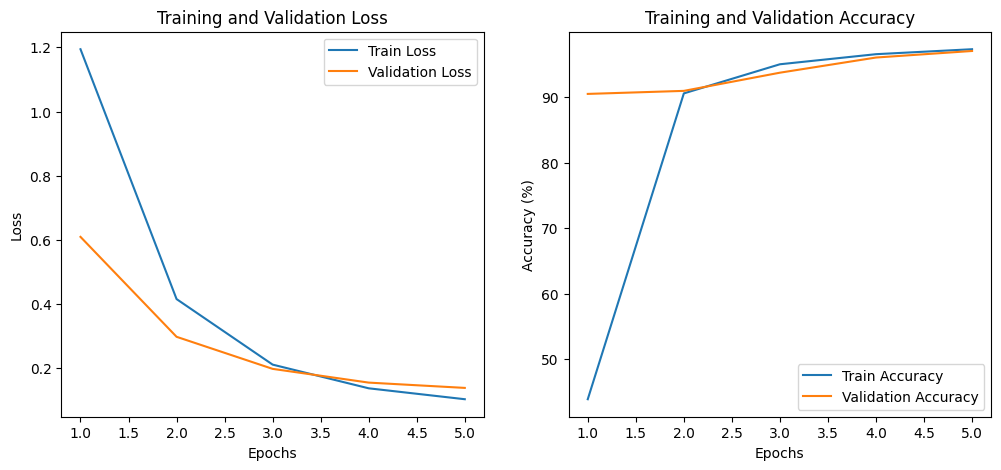

CNNModel(
  (conv1): Conv1d(1, 64, kernel_size=(16,), stride=(16,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7296, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=4, bias=True)
)

In [10]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

In [11]:
prune_ratio = 0.70  # 필터의 50% 제거
model.eval()  # 프루닝은 eval 모드에서 수행
model = detect_and_apply_l1_norm_pruning_for_filters(model, prune_ratio=prune_ratio)

print("L1-norm-based filter pruning completed.")

Pruned 44 filters from conv1.
Pruned 22 filters from conv2.
Pruned 44 filters from conv3.
Pruned 89 filters from conv4.
L1-norm-based filter pruning applied. 199 filters pruned in total.
L1-norm-based filter pruning completed.


Epoch 1/15: 100%|██████████| 788/788 [00:07<00:00, 108.29batch/s, accuracy=43.7, loss=1.3]


Epoch [1/15], Loss: 1.5390, Accuracy: 43.65%, Val Loss: 1.2531, Val Accuracy: 74.81%


Epoch 2/15: 100%|██████████| 788/788 [00:07<00:00, 104.09batch/s, accuracy=50.4, loss=1.28]


Epoch [2/15], Loss: 1.2799, Accuracy: 50.35%, Val Loss: 1.2159, Val Accuracy: 49.96%


Epoch 3/15: 100%|██████████| 788/788 [00:07<00:00, 108.89batch/s, accuracy=56.6, loss=1.24]


Epoch [3/15], Loss: 1.2528, Accuracy: 56.58%, Val Loss: 1.1735, Val Accuracy: 69.00%


Epoch 4/15: 100%|██████████| 788/788 [00:07<00:00, 104.96batch/s, accuracy=57.2, loss=1.25]


Epoch [4/15], Loss: 1.2239, Accuracy: 57.17%, Val Loss: 1.1338, Val Accuracy: 71.00%


Epoch 5/15: 100%|██████████| 788/788 [00:07<00:00, 107.29batch/s, accuracy=58, loss=1.14]


Epoch [5/15], Loss: 1.1924, Accuracy: 58.04%, Val Loss: 1.0950, Val Accuracy: 69.74%


Epoch 6/15: 100%|██████████| 788/788 [00:07<00:00, 106.21batch/s, accuracy=61.6, loss=1.05]


Epoch [6/15], Loss: 1.1594, Accuracy: 61.57%, Val Loss: 1.0571, Val Accuracy: 71.83%


Epoch 7/15: 100%|██████████| 788/788 [00:07<00:00, 104.42batch/s, accuracy=61.1, loss=0.995]


Epoch [7/15], Loss: 1.1257, Accuracy: 61.14%, Val Loss: 1.0226, Val Accuracy: 51.67%


Epoch 8/15: 100%|██████████| 788/788 [00:07<00:00, 109.19batch/s, accuracy=67.6, loss=1.01]


Epoch [8/15], Loss: 1.0920, Accuracy: 67.63%, Val Loss: 0.9882, Val Accuracy: 54.46%


Epoch 9/15: 100%|██████████| 788/788 [00:07<00:00, 103.82batch/s, accuracy=70.8, loss=1.01]


Epoch [9/15], Loss: 1.0586, Accuracy: 70.82%, Val Loss: 0.9472, Val Accuracy: 81.39%


Epoch 10/15: 100%|██████████| 788/788 [00:07<00:00, 109.43batch/s, accuracy=71.2, loss=0.956]


Epoch [10/15], Loss: 1.0259, Accuracy: 71.18%, Val Loss: 0.9188, Val Accuracy: 85.98%


Epoch 11/15: 100%|██████████| 788/788 [00:07<00:00, 103.02batch/s, accuracy=73.8, loss=0.933]


Epoch [11/15], Loss: 0.9938, Accuracy: 73.81%, Val Loss: 0.9029, Val Accuracy: 69.56%


Epoch 12/15: 100%|██████████| 788/788 [00:07<00:00, 106.62batch/s, accuracy=75.5, loss=0.931]


Epoch [12/15], Loss: 0.9647, Accuracy: 75.46%, Val Loss: 0.8599, Val Accuracy: 74.33%


Epoch 13/15: 100%|██████████| 788/788 [00:07<00:00, 105.28batch/s, accuracy=78.1, loss=0.912]


Epoch [13/15], Loss: 0.9351, Accuracy: 78.14%, Val Loss: 0.8405, Val Accuracy: 70.78%


Epoch 14/15: 100%|██████████| 788/788 [00:07<00:00, 105.78batch/s, accuracy=77.7, loss=0.937]


Epoch [14/15], Loss: 0.9082, Accuracy: 77.71%, Val Loss: 0.8235, Val Accuracy: 82.20%


Epoch 15/15: 100%|██████████| 788/788 [00:07<00:00, 108.23batch/s, accuracy=80.4, loss=0.918]


Epoch [15/15], Loss: 0.8833, Accuracy: 80.40%, Val Loss: 0.8039, Val Accuracy: 76.93%


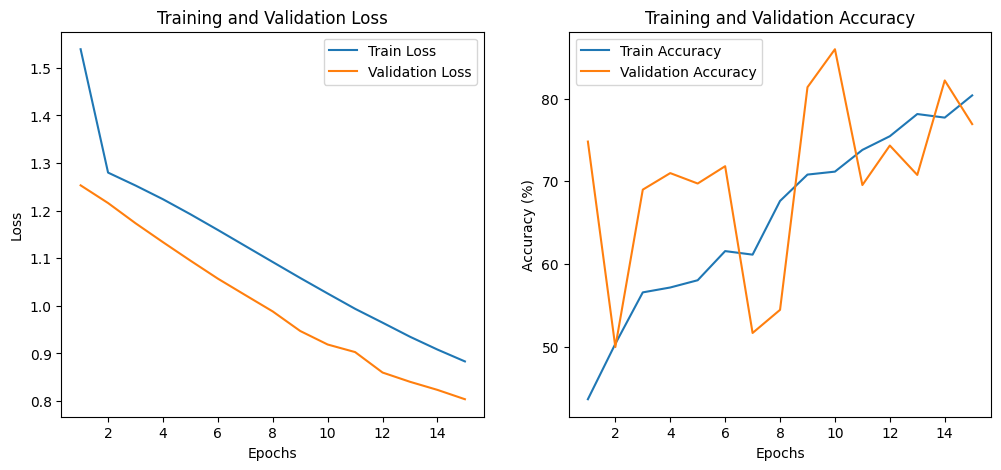

CNNModel(
  (conv1): Conv1d(1, 20, kernel_size=(16,), stride=(16,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(20, 10, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(10, 20, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(20, 39, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2223, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=4, bias=True)
)

In [12]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

In [13]:
# 최종 테스트 평가
print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.8005, Final Test Accuracy: 78.17%


In [14]:
# 모델 평가 함수 (혼동 행렬 포함)
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total
    return val_loss / total, accuracy, conf_matrix

Test Loss: 0.0251
Test Accuracy: 78.17%
Confusion Matrix:
[[1301   49    0    0]
 [  15 1335    0    0]
 [   1   82  235 1032]
 [   0    0    0 1350]]


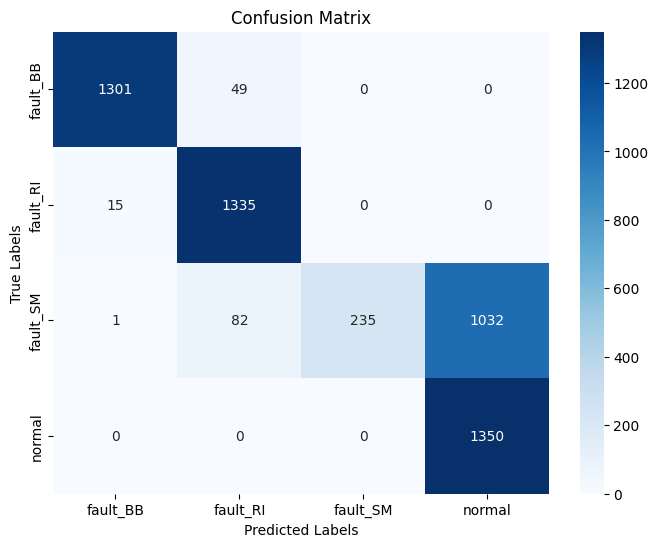

In [15]:
# 혼동 행렬 시각화 함수
def plot_confusion_matrix(conf_matrix, label_encoder):
    categories = label_encoder.classes_  # LabelEncoder의 순서대로 클래스 레이블을 가져옴
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# 테스트 데이터 평가
test_loss, test_accuracy, test_conf_matrix = evaluate_model(model, test_loader, criterion)

# 결과 출력
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(test_conf_matrix)


# 혼동 행렬 시각화
plot_confusion_matrix(test_conf_matrix, label_encoder)

In [16]:
# 모델 구조 출력
print(model)

# 입력 데이터로 테스트
test_input = torch.randn(1, 1, input_length).to(next(model.parameters()).device)
output = model(test_input)
print(f"Output shape: {output.shape}")

CNNModel(
  (conv1): Conv1d(1, 20, kernel_size=(16,), stride=(16,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(20, 10, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(10, 20, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(20, 39, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2223, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=4, bias=True)
)
Output shape: torch.Size([1, 4])


In [17]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB

    if model_size < 1:
        return model_size * 1024  # Convert to KB if size is less than 1MB
    return model_size

In [18]:
model_size = get_model_size(model)

if model_size < 1:
    print(f'Model size: {model_size * 1024:.2f} KB')
else:
    print(f'Model size: {model_size:.2f} MB')

Model size: 61.53 MB


In [19]:
# 모델 저장
torch.save(model.state_dict(), "pruned_model.pth")

# 파일 크기 확인
file_size = os.path.getsize("pruned_model.pth") / 1024**2  # MB로 변환
print(f"모델 크기: {file_size:.2f} MB")

모델 크기: 61.54 MB


In [20]:
# F1 스코어 계산
def calculate_f1_score(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1 Score: {f1:.4f}")

In [21]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()  # 0이 아닌 가중치 수 계산
            total_count += param.numel()  # 전체 가중치 수 계산
    return nonzero_count, total_count

# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 16130913
Total number of weights: 16130913
Percentage of non-zero weights: 100.00%


In [22]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# FLOPs 계산 함수
def calculate_flops(model, input_size):
    model.eval()  # 평가 모드로 전환
    dummy_input = torch.randn(*input_size).to(device)  # 가짜 입력 생성
    flops = FlopCountAnalysis(model, dummy_input)
    return flops

# 입력 크기 정의 (배치 크기, 채널, 길이)
input_size = (1, 1, input_length)  # 배치 크기 1, 채널 1, input_length 사용

# FLOPs 계산
flops = calculate_flops(model, input_size)

# 결과 출력
print(f"Total FLOPs: {flops.total() / 1e6:.2f} MFLOPs")  # FLOPs를 MegaFLOPs 단위로 변환
print(flop_count_table(flops))

Total FLOPs: 16.84 MFLOPs
| module         | #parameters or shape   | #flops   |
|:---------------|:-----------------------|:---------|
| model          | 16.131M                | 16.84M   |
|  conv1         |  0.34K                 |  80K     |
|   conv1.weight |   (20, 1, 16)          |          |
|   conv1.bias   |   (20,)                |          |
|  conv2         |  0.61K                 |  73.8K   |
|   conv2.weight |   (10, 20, 3)          |          |
|   conv2.bias   |   (10,)                |          |
|  conv3         |  1.02K                 |  0.119M  |
|   conv3.weight |   (20, 10, 5)          |          |
|   conv3.bias   |   (20,)                |          |
|  conv4         |  3.939K                |  0.449M  |
|   conv4.weight |   (39, 20, 5)          |          |
|   conv4.bias   |   (39,)                |          |
|  fc1           |  11.12M                |  11.115M |
|   fc1.weight   |   (5000, 2223)         |          |
|   fc1.bias     |   (5000,)           

In [23]:
print("\nCalculating F1 Score...")
calculate_f1_score(model, test_loader, device)


Calculating F1 Score...
F1 Score: 0.7359


In [24]:
# 파라미터 수 계산 함수
def calculate_total_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")

In [25]:
print("\nCalculating Total Parameters...")
calculate_total_params(model)


Calculating Total Parameters...
Total Parameters: 16,130,913


In [26]:
# 자원 제한 설정 함수
def setup_limited_resources(cpu_only=True, num_threads=2):
    if cpu_only:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CPU 환경일 경우 스레드 수 제한
    if device.type == "cpu":
        torch.set_num_threads(num_threads)
        print(f"CPU 환경: 스레드 수를 {num_threads}개로 제한합니다.")
    else:
        print(f"GPU 환경: {torch.cuda.get_device_name(0)} 사용 중.")

    return device

In [27]:
# 추론 시간 측정 함수
def measure_inference_time(model, input_data, device, iterations=100):
    model.eval()
    model.to(device)
    input_data = input_data.to(device)

    # 추론 시간 측정
    with torch.no_grad():
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_data)
        end_time = time.time()

    avg_time = (end_time - start_time) / iterations
    print(f"Average Inference Time: {avg_time * 1000:.2f} ms")
    return avg_time

In [28]:
# 1. 모델 저장
torch.save(model, "trained_model.pth")
print("Model saved as 'trained_model.pth'")

# 2. CPU 환경 설정
device_cpu = setup_limited_resources(cpu_only=True, num_threads=2)

# 3. 모델 로드
model = torch.load("trained_model.pth", map_location=device_cpu, weights_only=False)
model.to(device_cpu)
model.eval()
print("Model loaded and moved to CPU.")

Model saved as 'trained_model.pth'
CPU 환경: 스레드 수를 2개로 제한합니다.
Model loaded and moved to CPU.


In [29]:
# 데이터 로더에서 샘플 데이터 가져오기
for input_data, _ in test_loader:
    break  # 첫 번째 배치만 가져옴

# 배치에서 첫 번째 샘플 선택 (배치 크기 1로 설정)
input_data = input_data[0:1].to(device_cpu)

In [30]:
# 5. 제한된 환경에서 추론 시간 측정
print("\nMeasuring Inference Time on CPU...")
measure_inference_time(model, input_data, device_cpu, iterations=100)


Measuring Inference Time on CPU...
Average Inference Time: 10.98 ms


0.010983638763427735